### Import Necessary Libraries

In [1]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LeakyReLU, Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
import matplotlib.pyplot as plt

### User-defined functions
* To save training history

In [2]:
class MetricsCheckpoint(Callback):
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

* Plotting the learning or training curve of the trained CNN model

In [3]:
def plot_learning_curve(HistFileName, curve_type='acc'):
    plt.figure(figsize=(10,5))
    if curve_type=='acc':
        plot_title = 'Training Vs Validation Accuracy'
    else:
        plot_title = 'Training Vs Validation Loss'
    plt.title(plot_title)
    metrics = np.load(HistFileName+'.npy', allow_pickle=True)[()]
    filt = [curve_type] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs', size=15)
    plt.ylabel('Accuracy', size=15)
#     plt.savefig('./' + KrsLrcName + '.png')

* Draw the confusion matrix as an image 

In [4]:
def plot_confusion_matrix(cm, classes,confMatName,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#     plt.savefig('./' + confMatName + '.png')

### Proposed CNN Model for Training
* define the CNN model as a user-defined function

In [5]:
def eswa_bccdwbc_cnn_model(input_img_height, input_img_column, alphaVal, dropOut, num_classes):
    input_shape = (input_img_height, input_img_column, 3)
    input_img = Input(shape=input_shape, name='input_img')
    
    c1 = Conv2D(32, kernel_size=(2,2), strides=2, padding='valid', name='Conv1')(input_img)  #32x40x40
    c1 = LeakyReLU(alpha=alphaVal, name='Conv1_LeakyReLU')(c1)
    mp11 = AveragePooling2D(pool_size=(7,7), strides=3, padding='valid', name='AvgPool1_conv1')(c1)  #32x12x12
    mp12 = AveragePooling2D(pool_size=(8,8), strides=2, padding='valid', name='AvgPool2_conv1')(mp11)  #32x3x3
    drop11 = Dropout(dropOut[0], name='DropOut_AP2_Conv1')(mp12)
    
    mpIn = AveragePooling2D(pool_size=(2,2), strides=2, padding='valid', name='AvgPool_ForCCW_Conv1')(input_img)  #3x40x40
    mpIn2 = AveragePooling2D(pool_size=(3,3), strides=1, padding='valid', name='AvgPool_ForCCW_Conv3')(mpIn)  #3x38x38
    mpIn3 = AveragePooling2D(pool_size=(3,3), strides=1, padding='valid', name='AvgPool_ForCCW_Conv4')(mpIn2)  #3x36x36
    c1InCC = concatenate([mpIn, c1], name='CCW_Conv1', axis=-1) #35x40x40
    
    c2 = Conv2D(32, kernel_size=(2,2), strides=1, padding='valid', name='Conv2')(c1InCC)  #32x39x39
    c2 = LeakyReLU(alpha=alphaVal, name='Conv2_LeakyReLU')(c2)
    c3 = Conv2D(32, kernel_size=(2,2), strides=1, padding='valid', name='Conv3')(c2)   #32x38x38
    c3 = LeakyReLU(alpha=alphaVal, name='Conv3_LeakyReLU')(c3)
    c3InCC = concatenate([mpIn2, c3], name='CCW_Conv3', axis=-1) #35x38x38
    
    c4 = Conv2D(32, kernel_size=(3,3), strides=1, padding='valid', name='Conv4')(c3InCC)   #32x36x36
    c4 = LeakyReLU(alpha=alphaVal, name='Conv4_LeakyReLU')(c4)
    c4InCC = concatenate([mpIn3, c4], name='CCW_Conv4', axis=-1) #35x36x36
    
    c5 = Conv2D(32, kernel_size=(6,6), strides=2, padding='valid', name='Conv5')(c4InCC)   #32x16x16
    c5 = LeakyReLU(alpha=alphaVal, name='Conv5_LeakyReLU')(c5)
    mp5 = AveragePooling2D(pool_size=(8,8), strides=4, padding='valid', name='AvgPool_Conv5')(c5)  #32x3x3
    drop21 = Dropout(dropOut[1], name='DropOut_AP_Conv5')(mp5) #4,6
    
    merge_layer = concatenate([drop11, drop21], name='CC_AP12wAP5', axis=-1)
    
    flat = Flatten(name='Flat_For_HLIn')(merge_layer)
    fcl1 = Dense(128, name='Hidden_Layer1')(flat)
    fcl1 = LeakyReLU(alpha=alphaVal, name='Hidden_Layer1_act_LeakyReLU')(fcl1)
    dropf1 = Dropout(dropOut[2], name='DropOut_HL1')(fcl1)
    output_layer = Dense(num_classes, activation='softmax', name='Output_Layer')(dropf1)
    
    model = Model(inputs=[input_img], outputs=[output_layer])
    
    return model

* Now load the <b>.npz</b> file. Then set the training hyperparameters to train the proposed CNN model for 100 epochs. Before training the following code save the CNN model as <b>.json</b> file. During the training, only the best weights will be saved based on the validation accuracy improvement.

In [6]:
# CNN Model input image size
img_rows,img_cols = 80,80

# WBC_CNN_Model Activation Function Parameter
alphaVal=0.1

# Dropout Layer Parameter
DropMat = [0.3,0,0.1]

# Parameter for training the WBC_CNN_Model
learning_rate = 0.0001
batch_size = 8
epochs = 100

# Loading train-test BCCD Database
npzfile = np.load('eswa_train_test_bccdwbc_seg_80x80.npz')
num_classes = len(npzfile["y_trainHot"][0])
# call WBC_CNN Model
model = eswa_bccdwbc_cnn_model(img_rows, img_cols, alphaVal, DropMat, num_classes)
# Set Optimizer and its Parameter to train the model
model.compile(loss=categorical_crossentropy,
              optimizer=optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])
# Show the layers and parameter size of the CNN model
model.summary()

# Save the model as .json file
modelName = 'eswa_bccdwbc_cnn_model'
model_json = model.to_json()
with open(modelName + '.json', 'w') as json_file:
    json_file.write(model_json)

# Set Random rotation of training dataset during training
datagen = ImageDataGenerator(
featurewise_center=False,  # set input mean to 0 over the dataset
samplewise_center=False,  # set each sample mean to 0
featurewise_std_normalization=False,  # divide inputs by std of the dataset
samplewise_std_normalization=False,  # divide each input by its std
zca_whitening=False,  # apply ZCA whitening
rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
horizontal_flip=True,  # randomly flip images
vertical_flip=False)  # randomly flip images

# Save the best weights based on the higher accuracy of Validation Dataset
WeightFileName = 'eswa_bccdwbc_cnn_weights'
checkpointer = ModelCheckpoint(filepath = WeightFileName+'.hdf5', monitor='val_accuracy',
                               verbose=1, save_best_only=True)
# Set the training parameter to train the CNN model
history = model.fit(datagen.flow(npzfile["X_train"], npzfile["y_trainHot"], batch_size=batch_size),
                    steps_per_epoch=len(npzfile["X_train"]) / batch_size, epochs=epochs,
                    validation_data = [npzfile["X_test"], npzfile["y_testHot"]],
                    callbacks = [checkpointer, MetricsCheckpoint('eswa_bccdwbc_cnn_training_logs')])
    
    

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 40, 40, 32)   416         input_img[0][0]                  
__________________________________________________________________________________________________
Conv1_LeakyReLU (LeakyReLU)     (None, 40, 40, 32)   0           Conv1[0][0]                      
__________________________________________________________________________________________________
AvgPool_ForCCW_Conv1 (AveragePo (None, 40, 40, 3)    0           input_img[0][0]                  
______________________________________________________________________________________________

* To plot the learning curve of the trained CNN model, the trained CNN model with best weights should be loaded. Then by calling the `plot_learning_curve()` function, the training history is displayed interms of accuracy and loss.

In [7]:
WeightFileName = 'eswa_bccdwbc_cnn_weights'
model.load_weights(WeightFileName + '.hdf5', by_name=False)
w1=model.get_weights()
model.set_weights(w1)

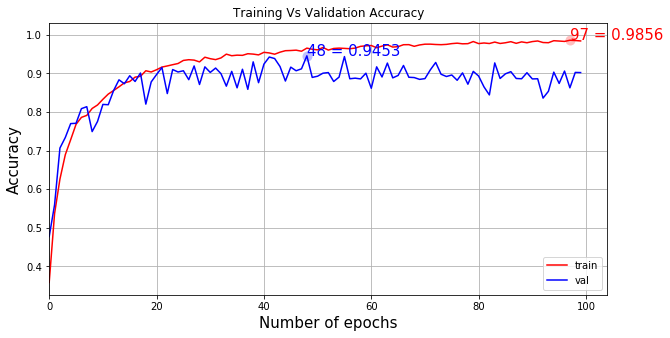

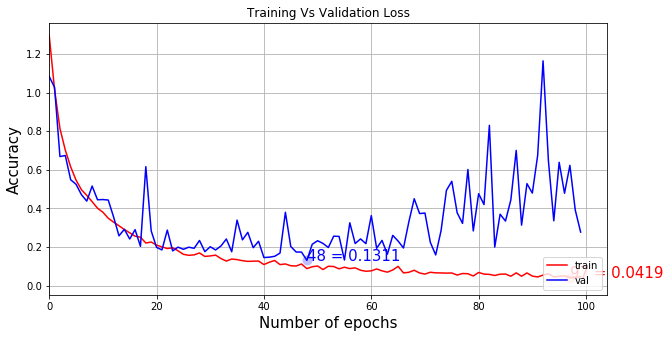

In [8]:
plot_learning_curve(HistFileName='eswa_bccdwbc_cnn_training_logs', curve_type='acc')
plt.show()
plot_learning_curve(HistFileName='eswa_bccdwbc_cnn_training_logs', curve_type='loss')
plt.show()

* To draw the confusion matrix, the confusion matrix is needed to calculate on train dataset. Then, by calling the `plot_confusion_matrix()` function, the confusion matrix is drawn.


              precision    recall  f1-score   support

  Neutrophil       0.96      0.97      0.96      2635
  Eosinophil       0.98      0.96      0.97      2572
    Monocyte       0.99      1.00      1.00      2494
  Lymphocyte       1.00      1.00      1.00      2505

    accuracy                           0.98     10206
   macro avg       0.98      0.98      0.98     10206
weighted avg       0.98      0.98      0.98     10206



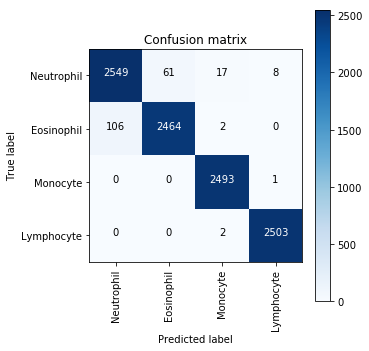

In [9]:
dict_characters = {1:'Neutrophil', 2:'Eosinophil', 3:'Monocyte', 4:'Lymphocyte'}
map_characters = dict_characters
y_pred = model.predict(npzfile["X_train"])
print('\n', classification_report(np.where(npzfile["y_trainHot"] > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
Y_pred_classes = np.argmax(y_pred, axis=1) 
Y_true = np.argmax(npzfile["y_trainHot"], axis=1)
cmm = confusion_matrix(Y_true, Y_pred_classes)
plot_confusion_matrix(cmm, classes = list(dict_characters.values()), confMatName='eswa_bccdwbc_cnn_training_cm')
plt.show()